In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [100]:
df = pd.read_csv('data/counts_vs_distance_proc.csv')
print(df.shape)
df.head()



(272, 2)


,distance,counts
0,bg,438
1,bg,445
2,bg,460
3,bg,469
4,bg,457


Dwell time was set to 10 seconds, so will divide this activity by 10.

In [101]:
df.loc[:,'counts'] = df['counts'] / 10

In [102]:
df.loc[:,'unc_counts'] = np.sqrt(df['counts'])


data = df.loc[df['distance'] != 'bg', :].reset_index(drop=True)
data.head()

,distance,counts,unc_counts
0,4.3,409.4,20.233635
1,4.3,420.0,20.493902
2,4.3,403.0,20.074860
3,4.3,421.1,20.520721
4,4.3,431.6,20.774985


In [103]:
background = df.loc[df['distance'] == 'bg', :]
background.shape
bg_mean = background['counts'].mean()

bg_std = background['counts'].std()
bg_err = bg_std / np.sqrt(background.shape[0])
print(f'Background Intensity: {bg_mean:.1f} +/- {bg_err:.1f} counts/sec')

Background Intensity: 46.6 +/- 0.3 counts/sec


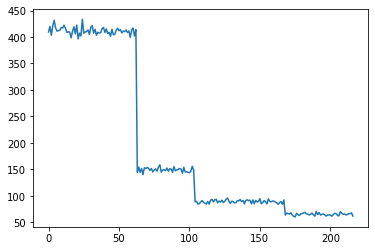

In [104]:
plt.plot(data.index, data['counts'])

<AxesSubplot:xlabel='distance', ylabel='counts'>

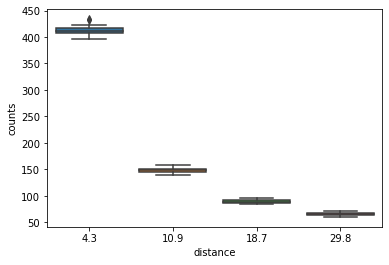

In [105]:
sns.boxplot(data=data, x='distance', y='counts')

In [106]:
count_df = data.drop('unc_counts', axis=1).groupby(['distance'], as_index=False).agg(['mean', 'std', 'count'])
count_df.columns = count_df.columns.get_level_values(1).astype(str)
count_df = count_df.reset_index()
count_df['distance'] = count_df['distance'].astype(float)
count_df

,distance,mean,std,count
0,10.9,149.158537,4.085950,41
1,18.7,89.148438,2.964659,64
2,29.8,65.155102,2.306608,49
3,4.3,411.582540,7.108776,63


In [107]:
count_df

,distance,mean,std,count
0,10.9,149.158537,4.085950,41
1,18.7,89.148438,2.964659,64
2,29.8,65.155102,2.306608,49
3,4.3,411.582540,7.108776,63


In [108]:
count_df['mean'] = count_df['mean'] - bg_mean
count_df = count_df.sort_values('distance')

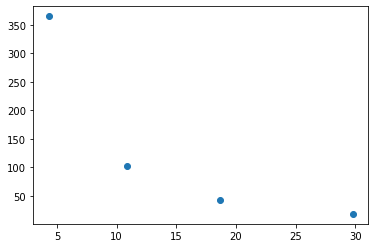

In [109]:
plt.scatter(x=count_df['distance'], y=count_df['mean'])

### Computing $r$

Assuming intensity is a function of distance, $y$:

$$I(y) = \frac{I_0}{(y + r)^2}$$

We don't have $I_0$ but do have $y$, and $I(y)$ and can take the ratio of two measurements:

$$\frac{I(y_1)}{I(y_2)} = \frac{(y_2 + r)^2}{(y_1 + r)^2}$$

And solve for a function of $r$:

Let $\alpha = \frac{I(y_1)}{I(y_2)}$

$$(\alpha - 1)r^2 + 2(\alpha y_1 - y_2)r + \alpha(y_1^2 - y_2^2) = 0$$

Which is just a quadratic function of $r$:
$$Ar^2 + Br + C = 0$$

In [110]:
count_df

,distance,mean,std,count
3,4.3,364.987994,7.108776,63
0,10.9,102.563991,4.085950,41
1,18.7,42.553892,2.964659,64
2,29.8,18.560557,2.306608,49


In [114]:
def quad(A, B, C):
    beta = np.sqrt(B**2 - 4*A*C)
    
    return ((-B + beta)/2/A, (-B - beta)/2/A )

for i in range(count_df.shape[0] - 1):
    alpha = count_df.iloc[i, 1] / count_df.iloc[i+1, 1]
    #print(alpha)
    A = (alpha - 1)
    B = 2 * (alpha * count_df.iloc[i, 1] - count_df.iloc[i+1, 1])
    C = alpha * (count_df.iloc[i, 1]**2 - count_df.iloc[i+1, 1]**2)
    #print(f'{A}r^2 + {B}r + {C}')
    print(f'r = {quad(A,B,C)}')

r = (-248.56797297540126, -686.535997742228)
r = (-66.5346105634085, -223.70115578914144)
r = (-27.434808163515495, -94.7940890999354)


In [118]:
count_df['distance'].to_numpy()

array([ 4.3, 10.9, 18.7, 29.8])

In [127]:
import numpy as np
from sklearn.linear_model import LinearRegression

# initial guess
r = 1
# Define the measured distances and intensities
y = count_df['distance'].to_numpy()
I = count_df['mean'].to_numpy()

# Define the model with an additional column for I0
X = np.column_stack((1 / (y + r)**2, np.ones_like(y)))

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, I)

# Extract the estimated values of r and I0 from the model coefficients
r_estimated = - model.coef_[0]**(-0.5) + y.mean()
I0_estimated = model.intercept_

In [128]:
print(f'r_estimate: {r_estimated}')
print(f'I0 estimate: {I0_estimated}')

r_estimate: 15.914894769451738
I0 estimate: 18.8334594202084


In [129]:
X

array([[0.03559986, 1.        ],
       [0.00706165, 1.        ],
       [0.00257672, 1.        ],
       [0.00105414, 1.        ]])